In [1]:
from qiskit import QuantumCircuit
from qiskit.quantum_info import partial_trace, Statevector
from qiskit.circuit.library import ZGate, XGate
from qiskit import execute, Aer
from qiskit.compiler import transpile
from qiskit.tools.visualization import plot_histogram
from matplotlib import pyplot as plt
from matplotlib import colors
import numpy as np
from pylab import *

In [2]:
def createSFblock(N, j):
    
    circuit = QuantumCircuit(N)
    
    state_decimal = format(j, '0'+str(N)+'b')[::-1] # inverse order due to Qiskit order: |q1q0>
    
    for qubit in range(N):
        if state_decimal[qubit] == '0':
            circuit.x(qubit)
    
    multiConrolledZ = ZGate().control(num_ctrl_qubits=N-1)
    circuit.append(multiConrolledZ, range(N))
    
    for qubit in range(N):
        if state_decimal[qubit] == '0':
            circuit.x(qubit)
    
    return circuit


In [3]:
def U_i(N, ki, circuit):
    
    # create equal superposition
    circuit.h(range(N))
    
    # apply SF blocks according to ki information
    vector_i = format(ki, '0'+str(2**N)+'b')
    for ij in range(len(vector_i)):
        if vector_i[ij] == '1': # n_j = 1, equivalent of having -1 in vector i
            circuit.compose(createSFblock(N, ij), inplace=True)  # the state i is the one that must have the phase of -1

def U_w(N, kw, circuit):
    
    # apply SF blocks according to kw information
    vector_w = format(kw, '0'+str(2**N)+'b')
    for wj in range(len(vector_w)):
        if vector_w[wj] == '1': # n_j = 1, equivalent of having -1 in vector w
            circuit.compose(createSFblock(N, wj), inplace=True)  # the state w is the one that must have the phase of -1
    
    # apply Hadamards
    circuit.h(range(N))
    
    # apply NOTs
    circuit.x(range(N))

In [4]:
def perceptron_brute_force(N, ki, kw, draw=False):
    
    # create circuit, N qubits + ancilla
    circuit = QuantumCircuit(N + 1, 1)
    
    # apply U_i
    U_i(N, ki, circuit)
    
    # apply U_w
    U_w(N, kw, circuit)
    
    # apply C^N X
    circuit.mcx(control_qubits=[i for i in range(N)], target_qubit=N)
    
    # measure the ancilla qubit
    circuit.measure(N, 0)
    
    # draw circuit
    if draw == True:
        display(circuit.draw('mpl'))
    
    return circuit

In [5]:
def draw_image(N, k):
        
    ns = format(k, '0'+str(2**N)+'b')
    
    fig, ax = plt.subplots(figsize=(2, 2))
        
    ax.grid(which='both', axis='both', linestyle='-', color='black', linewidth=1)

    cmap = colors.ListedColormap(['black', 'white']) # [0, 1]

    ax.set_xticks(np.arange(0.5, N, 1));
    ax.set_yticks(np.arange(0.5, N, 1));
    plt.tick_params(axis='both', which='both', bottom=False,   
                    left=False, labelbottom=False, labelleft=False)
    
    image_data = np.zeros((N, N))
    j = 0
    for (x,y), _ in np.ndenumerate(image_data):
        image_data[x][y] = int(ns[j])
        j += 1
    
    ax.imshow(image_data, cmap=cmap)
    
    plt.show()

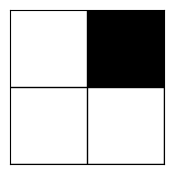

In [6]:
draw_image(N=2, k=11)

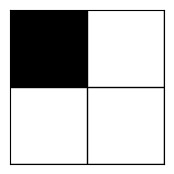

In [7]:
draw_image(N=2, k=7)

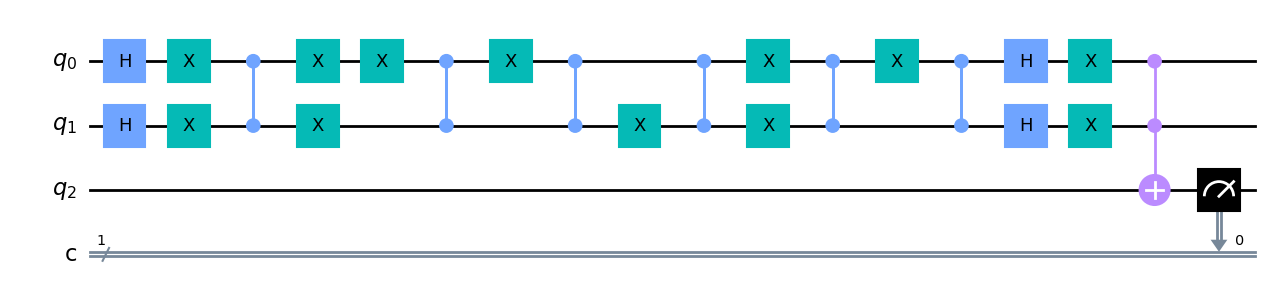

In [8]:
perceptron_circuit = perceptron_brute_force(N=2, ki=11, kw=7, draw=True) # equivalent to circuit in Fig 3c

In [9]:
simulator = Aer.get_backend('aer_simulator')

job = execute(perceptron_circuit, simulator, shots=1000)
counts = job.result().get_counts(perceptron_circuit)
print(counts)                                           # always 0, perceptron not activated

#plot_histogram(counts, title='Perceptron simulation with U_i and U_w in brute force')

{'0': 1000}


In [10]:
def perceptron_optimize_for_ki_11_kw_7(draw=False):   # as in Fig 3c, in qiskit must be inverted
    
    circuit = QuantumCircuit(3, 1)
    
    circuit.h(range(2))
    circuit.z(0)
    circuit.cz(0, 1)
    circuit.z(range(2))
    circuit.cz(0, 1)
    circuit.h(range(2))
    circuit.x(range(2))
    circuit.ccx(0, 1, 2)
    
    circuit.measure(2, 0)
    
    # draw circuit
    if draw == True:
        display(circuit.draw('mpl'))
    
    return circuit

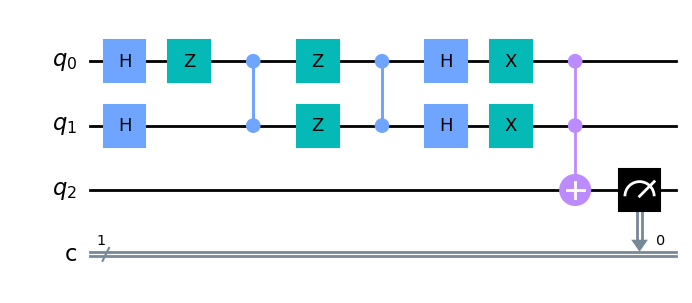

In [11]:
perceptron_circuit_for_ki_11_kw_7 = perceptron_optimize_for_ki_11_kw_7(draw=True)

In [12]:
job2 = execute(perceptron_circuit_for_ki_11_kw_7, simulator, shots=1000)
counts2 = job2.result().get_counts(perceptron_circuit_for_ki_11_kw_7)
print(counts2)                                           # always 0, perceptron not activated

#plot_histogram(counts2, title='Perceptron simulation as in Fig 3c')

{'0': 1000}


In [13]:
# Calculate for every value for ki and kw (simulation)

N = 2
shots = 1000

results_sim = []
for kw in range(2**(2**N)):
    results_sim.append([])
    for ki in range(2**(2**N)):
        perceptron_circuit = perceptron_brute_force(N, ki, kw)
        job = execute(perceptron_circuit, simulator, shots=shots)
        counts = job.result().get_counts(perceptron_circuit)
        if '1' in counts: results_sim[kw].append(counts['1']/shots)
        else: results_sim[kw].append(0)

In [14]:
# code from: https://stackoverflow.com/a/43119180/713780

def make_bar(ax, x0=0, y0=0, width = 0.5, height=1 , cmap="viridis",  
              norm=matplotlib.colors.Normalize(vmin=0, vmax=1), **kwargs ):
    # Make data
    u = np.linspace(0, 2*np.pi, 4+1)+np.pi/4.
    v_ = np.linspace(np.pi/4., 3./4*np.pi, 100)
    v = np.linspace(0, np.pi, len(v_)+2 )
    v[0] = 0 ;  v[-1] = np.pi; v[1:-1] = v_
    x = np.outer(np.cos(u), np.sin(v))
    y = np.outer(np.sin(u), np.sin(v))
    z = np.outer(np.ones(np.size(u)), np.cos(v))

    xthr = np.sin(np.pi/4.)**2 ;  zthr = np.sin(np.pi/4.)
    x[x > xthr] = xthr; x[x < -xthr] = -xthr
    y[y > xthr] = xthr; y[y < -xthr] = -xthr
    z[z > zthr] = zthr  ; z[z < -zthr] = -zthr

    x *= 1./xthr*width; y *= 1./xthr*width
    z += zthr
    z *= height/(2.*zthr)
    #translate
    x += x0; y += y0
    #plot
    ax.plot_surface(x, y, z, cmap=cmap, norm=norm, **kwargs)

def make_bars(ax, x, y, height, width=1):
    widths = np.array(width)*np.ones_like(x)
    x = np.array(x).flatten()
    y = np.array(y).flatten()

    h = np.array(height).flatten()
    w = np.array(widths).flatten()
    norm = matplotlib.colors.Normalize(vmin=0, vmax=1) #, vmax=h.max())
    for i in range(len(x.flatten())):
        make_bar(ax, x0=x[i], y0=y[i], width = w[i] , height=h[i], norm=norm)


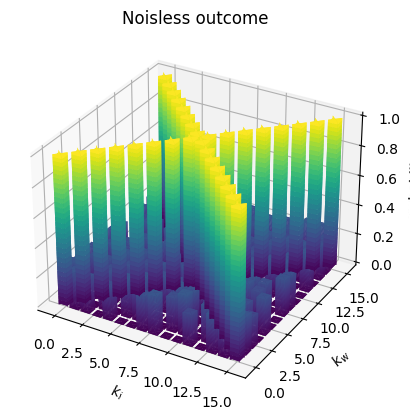

In [15]:
data_array = np.array(results_sim) # Convert it into an numpy array


fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

x_data, y_data = np.meshgrid( np.arange(data_array.shape[1]),
                              np.arange(data_array.shape[0]) )

x_data = x_data.flatten()
y_data = y_data.flatten()
z_data = data_array.flatten()

make_bars(ax, x_data, y_data, z_data, width=0.4)

ax.set_title("Noisless outcome")
ax.set_xlabel('$k_i$')
ax.set_ylabel('$k_w$')
ax.set_zlabel('probability')

plt.show()

In [16]:
# data_array = np.array(results) # Convert it into an numpy array


# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')

# x_data, y_data = np.meshgrid( np.arange(data_array.shape[1]),
#                               np.arange(data_array.shape[0]) )

# x_data = x_data.flatten()
# y_data = y_data.flatten()
# z_data = data_array.flatten()

# dx = 1
# dy = 1
# dz = z_data

# # setting color bar
# cmap = cm.get_cmap('viridis') # Get desired colormap - you can change this!
# max_height = np.max(dz)   # get range of colorbars so we can normalize
# min_height = np.min(dz)
# rgba = [cmap((k-min_height)/max_height) for k in dz] 

# barRes = ax.bar3d( x_data, y_data, np.zeros(len(z_data)), dx, dy, dz, cmap=cmap, color=rgba )

# plt.colorbar(barRes, shrink=0.5, aspect=5)

# ax.set_title("Noisless outcome")
# ax.set_xlabel('ki')
# ax.set_ylabel('kw')
# ax.set_zlabel('probability')

# plt.show()

In [188]:
from qiskit import IBMQ

#IBMQ.save_account('TOKEN')

IBMQ.load_account()

IBMQ.providers() 

[<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>,
 <AccountProvider for IBMQ(hub='ibm-q-community', group='ibmquantumawards', project='open-science-22')>,
 <AccountProvider for IBMQ(hub='qc-fall-22-5', group='group-1', project='recmcZjyMk2obFy9z')>]

In [189]:
provider = IBMQ.get_provider(hub='ibm-q')
provider.backends()

[<IBMQSimulator('ibmq_qasm_simulator') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_lima') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_belem') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_quito') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQSimulator('simulator_statevector') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQSimulator('simulator_mps') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQSimulator('simulator_extended_stabilizer') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQSimulator('simulator_stabilizer') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_manila') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibm_nairobi') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibm_oslo') from IBMQ(hub='ibm-q', group='open', project='main')>]

In [190]:
from qiskit.providers.ibmq import least_busy

devices = provider.backends(simulator=False, operational=True)

least_busy_device = least_busy(devices)

In [221]:
least_busy_device

<IBMQBackend('ibmq_belem') from IBMQ(hub='ibm-q', group='open', project='main')>

In [193]:
least_busy_device.configuration().n_qubits

5

In [196]:
# Calculate for every value for ki and kw

N = 2
shots = 1000

results = []
for kw in range(2**(2**N)):
    results.append([])
    for ki in range(2**(2**N)):
        perceptron_circuit = perceptron_brute_force(N, ki, kw)
        circuit_transpiled = transpile(perceptron_circuit, least_busy_device) # in this case the transpilation is necessary

        job = least_busy_device.run(circuit_transpiled, shots=shots)
        
        counts = job.result().get_counts()
        if '1' in counts: results[kw].append(counts['1']/shots)
        else: results[kw].append(0)

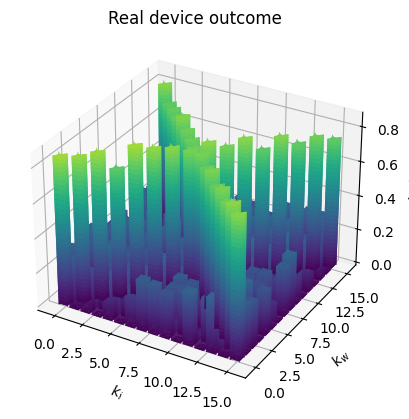

In [18]:
data_array = np.array(results) # Convert it into an numpy array


fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

x_data, y_data = np.meshgrid( np.arange(data_array.shape[1]),
                              np.arange(data_array.shape[0]) )

x_data = x_data.flatten()
y_data = y_data.flatten()
z_data = data_array.flatten()

make_bars(ax, x_data, y_data, z_data, width=0.4)

ax.set_title("Real device outcome")
ax.set_xlabel('$k_i$')
ax.set_ylabel('$k_w$')
ax.set_zlabel('probability')

plt.show()

In [204]:
# save data 'cause take approx 6 hours to run on the cloud device
with open("results_ibmq_belem_straightforward_Ui_Uw.txt", "w") as file:
    file.write(str(results))

In [24]:
#with open("results_ibmq_belem_straightforward_Ui_Uw.txt", "r") as file:
#    results = eval(file.readline())

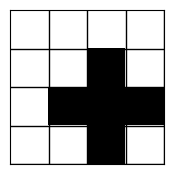

In [17]:
# weight vector for example for N=4 (Fig 4)
draw_image(N=4, k=64909)

In [18]:
# examples as in Fig 4

kis = [64911, 594, 64957, 610, 16311, 49664, 28415, 30653]

kw = 64909

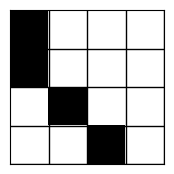

In [19]:
# show example 
draw_image(N=4, k=kis[7])

In [20]:
def get_probability_of_activation(N, ki, kw):
    perceptron_circuit = perceptron_brute_force(N=N, ki=ki, kw=kw)
    shots = 10000
    job = execute(perceptron_circuit, simulator, shots=shots)
    counts = job.result().get_counts(perceptron_circuit)
    if '1' in counts: return counts['1']/shots
    else: return 0

q.alg. = 0.7655


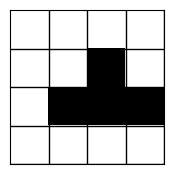

q.alg. = 0.7613


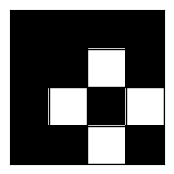

q.alg. = 0.5645


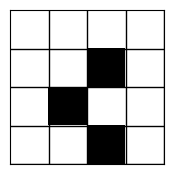

q.alg. = 0.7681


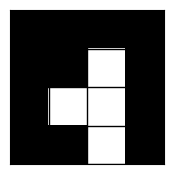

q.alg. = 0.0171


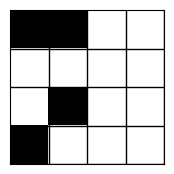

q.alg. = 0.0613


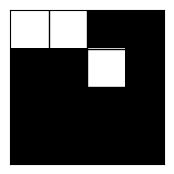

q.alg. = 0


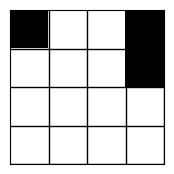

q.alg. = 0.1402


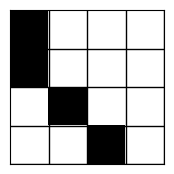

In [21]:
N=4
for ki in kis:
    prob = get_probability_of_activation(N, ki, kw)
    print("q.alg. =", prob)
    draw_image(N=N, k=ki)

Calculate the average discrepancy:

$$\mathcal{D}=\frac{\sum_{i,w}\big|O(i,w)-O_{ideal}(i,w)\big|}{2^{2^{N+1}}}$$

In [43]:
# load exact results (ideal)

with open("results_exact_Ui_Uw.txt", "r") as file:
    results_ideal = eval(file.readline())

In [44]:
# calculate average discrepancy

N = 2

D = np.sum(np.absolute(np.subtract(results, results_ideal))) / (2**(2**(N+1)))

D

0.09049999999999998

In [45]:
# calculate average discrepancy w.r.t. simulation

N = 2

D_sim = np.sum(np.absolute(np.subtract(results_sim, results_ideal))) / (2**(2**(N+1)))

D_sim

0.004957031250000087